# Benchmark

```python
X = sorted(np.random.uniform(0, 10, 1_000_000))

layers = [
    Linear(1,100, activation=Sigmoid()),
    Linear(100,1),
]
```

num_cpu 1 - 42.18422174453735

num_cpu 8 - 35.180429220199585

num_cpu 100 - 38.96385192871094

In [1]:
from typing import TypeAlias
import math
import time
import datetime
import json
import ctypes
import logging
import multiprocessing

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt


logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

formatter = logging.Formatter('[%(asctime)s] - %(name)s - %(levelname)s - %(message)s')

console_handler = logging.StreamHandler()

console_handler.setFormatter(formatter)
logger.addHandler(console_handler)

In [ ]:
!clang -shared -o main.so -fPIC -O3 -fopenmp -ffast-math -march=native main.c src/functions.c src/activations.c src/loss.c src/init.c src/json.c src/adam.c src/forward.c src/backward.c src/logger.c src/predict.c

In [2]:
lib = ctypes.CDLL('./main.so')


NUM_CPU = multiprocessing.cpu_count()

In [3]:
Sample: TypeAlias = list[int | float]
Samples: TypeAlias = list[Sample]

Target: TypeAlias = int | float
Targets: TypeAlias = list[Target]

Weights: TypeAlias = list[list[float]]

In [4]:
# Activation functions

def ReLU():
    return 0

def Sigmoid():
    return 1

def Softmax():
    return 2

def Empty():
    return 3

In [5]:
# Loss functions

def MSELoss():
    return 0

def CrossEntropy():
    return 1

In [6]:
class Dataset:
    def __init__(self, samples: Samples, targets: Targets) -> None:
        self.samples: Samples = np.array(samples)
        self._len = len(samples)
        self.targets: Targets = np.array(targets)

    def __len__(self) -> int:
        return self._len

    def __getitem__(self, index) -> Sample:
        return self.samples[index], self.targets[index]

    def __iter__(self):
        return iter(zip(self.samples, self.targets))

In [7]:
class Linear:
    def __init__(self, n_inputs: int, n_neurons: int, activation = None, dropout: float = 1.0) -> None:
        self.n_inputs = n_inputs
        self.n_neurons = n_neurons

        self.weights = []
        self.bias = []
        self.output = []

        if activation is None:
            self.activation = Empty()
        else:
            self.activation = activation
        
        self.dropout = dropout

Layers = list[Linear]

In [9]:
class Model:
    def __init__(self, layers: Layers, loss: int, regression: bool = True, max_change: float = 0.1, random_state: int = -1) -> None:
        self.layers = layers
        self._layers_len = len(layers)
        self.loss = loss
        self.regression = regression
        self.max_change = max_change
        self.random_state = random_state

    def fit(
        self,
        dataset: Dataset,
        n_epoch: int = 1,
        learning_rate: float = 0.01,
        verbose: bool = True,
        num_cpu: int = 1,
    ):
        if verbose:
            t = self.get_time()
            print(f"[{t}] - INFO - Preparing the dataset.")

        array_samples = []
        array_targets = []
        for sample, target in dataset:
            array_samples.append(sample)
            array_targets.append(target)
        array_samples = np.array(array_samples, dtype=np.float32)
        array_targets = np.array(array_targets, dtype=np.float32)

        layer_sizes = []
        activations = []
        for layer in self.layers:
            layer_sizes.append([float(layer.n_inputs), float(layer.n_neurons)])
            activations.append(layer.activation)

        layer_sizes = np.array(layer_sizes, dtype=np.float32)
        activations = np.array(activations, dtype=np.float32)

        dropouts = np.array([layer.dropout for layer in self.layers], dtype=np.float32)

        if verbose:
            t = self.get_time()
            print(f"[{t}] - INFO - Dataset preparation completed.")

        # Описываем аргументы нашей функции
        lib.fit.argtypes = [
            ctypes.POINTER(ctypes.c_float),
            ctypes.POINTER(ctypes.c_float),
            ctypes.c_int,
            ctypes.c_int,
            ctypes.c_int,
            ctypes.c_int,
            ctypes.c_int,
            ctypes.POINTER(ctypes.c_float),
            ctypes.c_int,
            ctypes.c_int,
            ctypes.POINTER(ctypes.c_float),
            ctypes.c_int,
            ctypes.c_int,
            ctypes.c_int,
            ctypes.c_float,
            ctypes.c_int,
            ctypes.c_float,
            ctypes.c_int,
            ctypes.c_int,
            ctypes.c_int,
            ctypes.POINTER(ctypes.c_float),
        ]

        if verbose:
            t = self.get_time()
            print(f"[{t}] - INFO - Training has started.")

        lib.fit(
            array_samples.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
            array_targets.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
            len(array_samples),
            len(array_samples[0]),
            len(array_samples[0][0]),
            len(array_targets),
            len(array_targets[0]),
            layer_sizes.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
            len(layer_sizes),
            len(layer_sizes[0]),
            activations.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
            len(activations),
            self.loss,
            n_epoch,
            learning_rate,
            verbose,
            self.max_change,
            self.random_state,
            self.regression,
            num_cpu,
            dropouts.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
        )

        if verbose:
            t = self.get_time()
            print(f"[{t}] - INFO - Training is over.")

        with open("weights.json", 'r') as file:
            weights = json.load(file)

        with open("biases.json", 'r') as file:
            biases = json.load(file)

        for i in range(self._layers_len):
            self.layers[i].weights = weights[i]
            self.layers[i].bias = biases[i]

    def predict_one(self, sample: Sample, predict_proba: bool = False) -> float:
        sample = np.array(sample)

        weights = [layer.weights for layer in self.layers]
        weights = self.flatten_3d_array(weights)
        weights = np.array(weights, dtype=np.float32)

        biases = [layer.bias for layer in self.layers]
        biases = self.flatten_3d_array(biases)
        biases = np.array(biases, dtype=np.float32)

        layer_sizes = []
        activations = []
        for layer in self.layers:
            layer_sizes.append([float(layer.n_inputs), float(layer.n_neurons)])
            activations.append(layer.activation)

        layer_sizes = np.array(layer_sizes, dtype=np.float32)
        activations = np.array(activations, dtype=np.float32)
        prediction = np.zeros(self.layers[self._layers_len - 1].n_neurons, dtype=np.float32)

        lib.predict_one.argtypes = [
            ctypes.POINTER(ctypes.c_float),
            ctypes.c_int,
            ctypes.c_int,
            ctypes.POINTER(ctypes.c_float),
            ctypes.POINTER(ctypes.c_float),
            ctypes.POINTER(ctypes.c_float),
            ctypes.c_int,
            ctypes.c_int,
            ctypes.POINTER(ctypes.c_float),
            ctypes.c_int,
            ctypes.POINTER(ctypes.c_float),
        ]

        lib.predict_one(
            sample.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
            len(sample),
            len(sample[0]),
            weights.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
            biases.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
            layer_sizes.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
            len(layer_sizes),
            len(layer_sizes[0]),
            activations.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
            len(activations),
            prediction.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
        )

        if predict_proba:
            return prediction
        if self.regression:
            return np.mean(prediction)
        return np.argmax(prediction)

    def predict(self, samples: Samples, predict_proba: bool = False, num_cpu: int = 1) -> float:
        samples = np.array(samples, dtype=np.float32)

        weights = [layer.weights for layer in self.layers]
        weights = self.flatten_3d_array(weights)
        weights = np.array(weights, dtype=np.float32)

        biases = [layer.bias for layer in self.layers]
        biases = self.flatten_3d_array(biases)
        biases = np.array(biases, dtype=np.float32)

        layer_sizes = []
        activations = []
        for layer in self.layers:
            layer_sizes.append([float(layer.n_inputs), float(layer.n_neurons)])
            activations.append(layer.activation)

        layer_sizes = np.array(layer_sizes, dtype=np.float32)
        activations = np.array(activations, dtype=np.float32)

        samples_len = len(samples)
        n_neurons_last = self.layers[self._layers_len - 1].n_neurons
        predictions = np.zeros(samples_len * n_neurons_last, dtype=np.float32)

        lib.predict.argtypes = [
            ctypes.POINTER(ctypes.c_float),
            ctypes.c_int,
            ctypes.c_int,
            ctypes.c_int,
            ctypes.POINTER(ctypes.c_float),
            ctypes.POINTER(ctypes.c_float),
            ctypes.POINTER(ctypes.c_float),
            ctypes.c_int,
            ctypes.c_int,
            ctypes.POINTER(ctypes.c_float),
            ctypes.c_int,
            ctypes.POINTER(ctypes.c_float),
            ctypes.c_int,
        ]

        lib.predict(
            samples.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
            len(samples),
            len(samples[0]),
            len(samples[0][0]),
            weights.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
            biases.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
            layer_sizes.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
            len(layer_sizes),
            len(layer_sizes[0]),
            activations.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
            len(activations),
            predictions.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
            num_cpu,
        )

        predictions_2d = []
        for i in range(samples_len):
            sample = []
            for j in range(n_neurons_last):
                index = i * n_neurons_last + j
                sample.append(predictions[index])
            predictions_2d.append(sample)

        if predict_proba:
            return predictions_2d
        if self.regression:
            result = np.array([np.mean(sample) for sample in predictions_2d])
            return result

        result = np.array([np.argmax(sample) for sample in predictions_2d])
        return result

    def flatten_3d_array(self, arr) -> list[float]:
        flat_list = []
        for row in arr:
            for subarr in row:
                flat_list.extend(subarr)
        return flat_list

    def set_weights(self, weights: Weights) -> None:
        for w, layer in zip(weights, self.layers):
            layer.weights = w
    
    def get_time(self) -> str:
        return datetime.datetime.now().strftime("%d-%m-%Y %H:%M:%S")

    @property
    def weights(self) -> Weights:
        weights = [layer.weights for layer in self.layers]
        return weights

## Dataset

In [56]:
X = sorted(np.random.uniform(0, 10, 10_000))
y = [[math.cos(x)] for x in X]

X_nested = list(X)
for i in range(len(X)):
    X_nested[i] = [[X[i]]]

X_nested = np.array(X_nested)

X_train, X_val, y_train, y_val = train_test_split(X_nested, y, train_size=0.8)

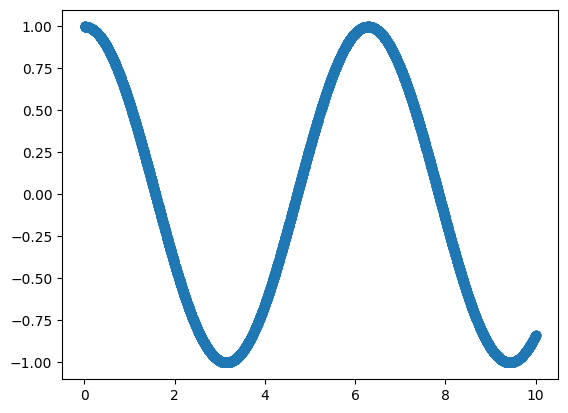

In [47]:
plt.plot(X, y, 'o')
plt.show()

[03-08-2025 18:07:54] - INFO - Preparing the dataset.
[03-08-2025 18:07:54] - INFO - Dataset preparation completed.
[03-08-2025 18:07:54] - INFO - Training has started.
[03-08-2025 18:07:54] - INFO - Forward step
[03-08-2025 18:07:54] - INFO - Backward step
[03-08-2025 18:07:55] - INFO - Update weights and biases step
[03-08-2025 18:07:55] - INFO - Epoch 1 / 1. Loss: 3.642894
[03-08-2025 18:07:55] - INFO - Training is over.


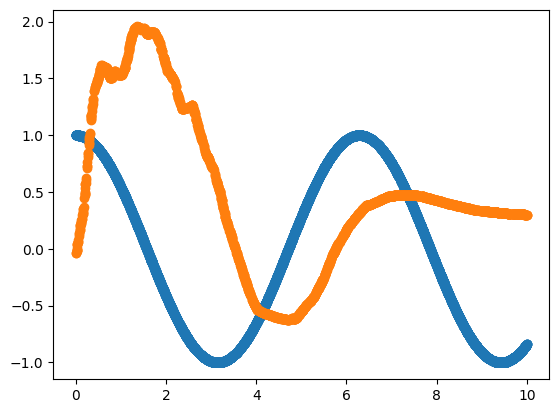

In [87]:
lib = ctypes.CDLL('./main.so')

train_dataset = Dataset(samples=X_train, targets=y_train)

layers = [
    Linear(1,100, activation=Sigmoid(), dropout=0.2),
    Linear(100,100, activation=Sigmoid(), dropout=0.2),
    Linear(100,100, activation=Sigmoid(), dropout=0.2),
    Linear(100,1),
]

model = Model(layers=layers, loss=MSELoss(), regression=True, max_change=0.000000000001)
model.fit(dataset=train_dataset, n_epoch=1, learning_rate=0.1, verbose=True, num_cpu=NUM_CPU)

predictions = model.predict(X_val)


plt.plot(X_train.reshape(-1, 1), y_train, 'o')
plt.plot(X_val.reshape(-1, 1), predictions, 'o')
plt.show()

# LinearRegression

In [14]:
from sklearn.linear_model import LinearRegression

In [15]:
sklearn_X_train = np.array(X_train)
sklearn_X_train = sklearn_X_train.reshape(-1, 1)

sklearn_y_val = np.array(y_val)
sklearn_y_val = sklearn_y_val.reshape(-1, 1)

In [16]:
sklearn_model = LinearRegression().fit(sklearn_X_train, y_train)

In [17]:
sklearn_preds = sklearn_model.predict(sklearn_y_val)

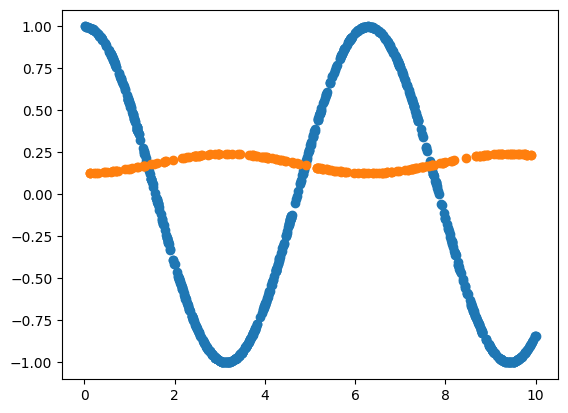

In [18]:
plt.plot(sklearn_X_train, y_train, 'o')
plt.plot(X_val, sklearn_preds, 'o')
plt.show()

# MLPRegressor

In [19]:
from sklearn.neural_network import MLPRegressor

In [20]:
sklearn_model = MLPRegressor(random_state=0).fit(sklearn_X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1770: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [21]:
sklearn_preds = sklearn_model.predict(sklearn_y_val)

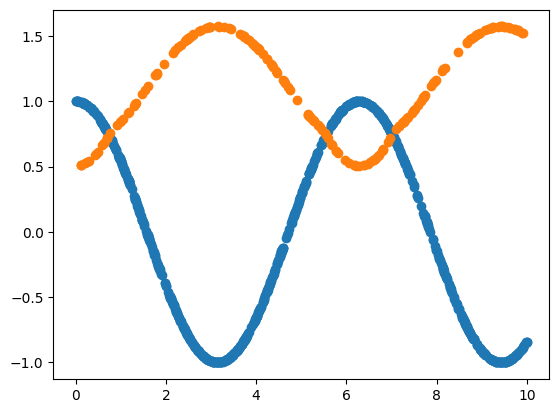

In [22]:
plt.plot(sklearn_X_train, y_train, 'o')
plt.plot(X_val, sklearn_preds, 'o')
plt.show()

# Make Moons dataset

In [10]:
from sklearn.datasets import make_moons

In [11]:
X, y = make_moons(n_samples=5000, noise=0.2)

X_nested = list(X)
for i in range(len(X)):
    X_nested[i] = [X[i]]

y = list(y)
for i in range(len(y)):
    if y[i] == 0:
        y[i] = np.array([1, 0])
    elif y[i] == 1:
        y[i] = np.array([0, 1])

y = np.array(y)

X_nested = np.array(X_nested)

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_nested, y, train_size=0.8)

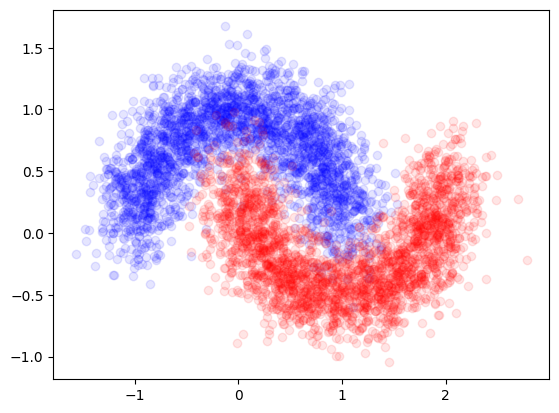

In [12]:
class_1_X = []
class_2_X = []

class_1_y = []
class_2_y = []

class_1_color = "blue"
class_2_color = "red"

for i in range(len(y)):
    if list(y[i]) == [1, 0]:
        class_1_X.append(X[i][0])
        class_1_y.append(X[i][1])
    elif list(y[i]) == [0, 1]:
        class_2_X.append(X[i][0])
        class_2_y.append(X[i][1])


plt.plot(class_1_X, class_1_y, 'o', color=class_1_color, alpha=0.1)
plt.plot(class_2_X, class_2_y, 'o', color=class_2_color, alpha=0.1)
plt.show()

In [ ]:
lib = ctypes.CDLL('./main.so')

train_dataset = Dataset(samples=X_train, targets=y_train)

layers = [
    Linear(2,100, activation=Sigmoid(), dropout=0.2),
    Linear(100,100, activation=Sigmoid(), dropout=0.2),
    Linear(100,100, activation=Sigmoid(), dropout=0.2),
    Linear(100,2, activation=Softmax()),
]

model = Model(layers=layers, loss=CrossEntropy(), regression=False, max_change=0.000001)
model.fit(dataset=train_dataset, n_epoch=1, learning_rate=0.1, verbose=True, num_cpu=NUM_CPU)

Preparing the dataset.
Dataset preparation completed.
Training has started.
Epoch 1 / 1. Loss: -0.649200
Training is over.


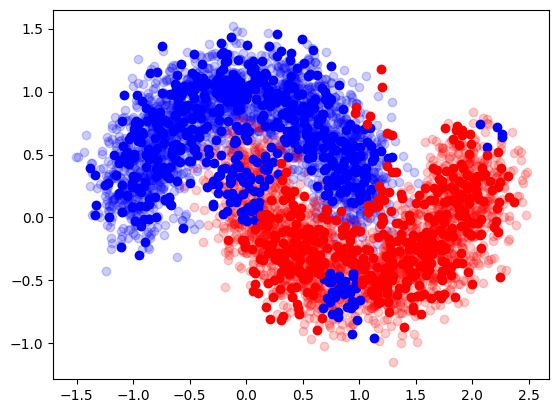

In [181]:
class_1_X_test = []
class_2_X_test = []

class_1_y_test = []
class_2_y_test = []


predictions = model.predict(X_val)

for i in range(len(X_val)):
    prediction = predictions[i]
    sample = X_val[i]
    if prediction == 0:
        class_1_X_test.append(sample[0][0])
        class_1_y_test.append(sample[0][1])
    elif prediction == 1:
        class_2_X_test.append(sample[0][0])
        class_2_y_test.append(sample[0][1])

plt.plot(class_1_X, class_1_y, 'o', color=class_1_color, alpha=0.2)
plt.plot(class_2_X, class_2_y, 'o', color=class_2_color, alpha=0.2)
plt.plot(class_1_X_test, class_1_y_test, 'o', color=class_1_color, alpha=1)
plt.plot(class_2_X_test, class_2_y_test, 'o', color=class_2_color, alpha=1)
plt.show()

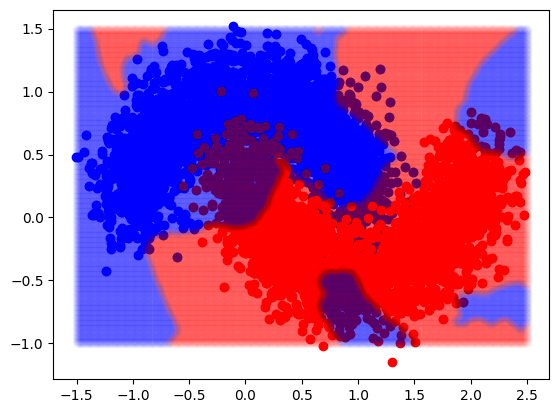

In [182]:
class_1_X = []
class_2_X = []

class_1_y = []
class_2_y = []

class_1_color = "blue"
class_2_color = "red"

for i in range(len(y)):
    if list(y[i]) == [1, 0]:
        class_1_X.append(X[i][0])
        class_1_y.append(X[i][1])
    elif list(y[i]) == [0, 1]:
        class_2_X.append(X[i][0])
        class_2_y.append(X[i][1])

class_1_X_test = []
class_2_X_test = []

class_1_y_test = []
class_2_y_test = []

x_min, x_max = -1.5, 2.5
y_min, y_max = -1, 1.5
step = 0.01

# Создаем равномерную сетку узлов (X,Y)
xx, yy = np.meshgrid(np.arange(x_min, x_max + step, step),
                     np.arange(y_min, y_max + step, step))

points = np.c_[xx.ravel(), yy.ravel()]


points_nested = []
for i in range(len(points)):
    sample = [points[i]]
    points_nested.append(sample)

predictions = model.predict(points_nested)

for i in range(len(points_nested)):
    sample = points_nested[i]
    prediction = predictions[i]

    if prediction == 0:
        class_1_X_test.append(sample[0][0])
        class_1_y_test.append(sample[0][1])
    elif prediction == 1:
        class_2_X_test.append(sample[0][0])
        class_2_y_test.append(sample[0][1])

plt.plot(class_1_X, class_1_y, 'o', color=class_1_color, alpha=1)
plt.plot(class_2_X, class_2_y, 'o', color=class_2_color, alpha=1)
plt.plot(class_1_X_test, class_1_y_test, 'o', color=class_1_color, alpha=0.01)
plt.plot(class_2_X_test, class_2_y_test, 'o', color=class_2_color, alpha=0.01)
plt.show()

# Sklearn MNIST dataset

In [415]:
from sklearn.datasets import load_digits

In [416]:
dataset = load_digits(n_class=2)

In [417]:
X, y = dataset.data, dataset.target

# for i in range(len(X)):
#     X[i] /= 255

X_reshaped = []
for i in range(len(X)):
    x = [X[i]]
    X_reshaped.append(x)

y_one_hot = np.zeros(len(y))
y_one_hot = list(y_one_hot)
for i in range(len(y)):
    if y[i] == 0:
        y_one_hot[i] = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    elif y[i] == 1:
        y_one_hot[i] = np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
    elif y[i] == 2:
        y_one_hot[i] = np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])
    elif y[i] == 3:
        y_one_hot[i] = np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])
    elif y[i] == 4:
        y_one_hot[i] = np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
    elif y[i] == 5:
        y_one_hot[i] = np.array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
    elif y[i] == 6:
        y_one_hot[i] = np.array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
    elif y[i] == 7:
        y_one_hot[i] = np.array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])
    elif y[i] == 8:
        y_one_hot[i] = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])
    elif y[i] == 9:
        y_one_hot[i] = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

y_one_hot = np.array(y_one_hot)

X_train, X_val, y_train_one_hot, y_val_one_hot = train_test_split(X_reshaped, y_one_hot, train_size=0.8)

In [418]:
X[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [419]:
y_val = np.zeros(len(y_val_one_hot), dtype=int)

for i in range(len(y_val_one_hot)):
    for j in range(len(y_val_one_hot[i])):
        if y_val_one_hot[i][j] == 1:
            y_val[i] = j
            break

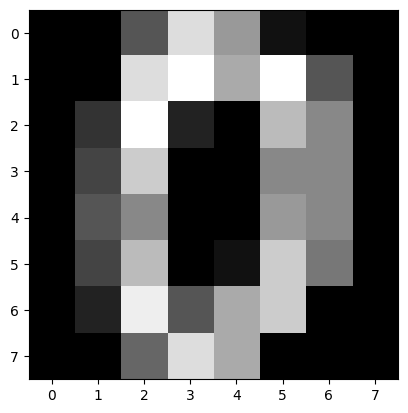

In [420]:
plt.imshow(X[0].reshape(8,8), cmap='gray')
plt.show()

In [492]:
lib = ctypes.CDLL('./main.so')

train_dataset = Dataset(samples=X_train, targets=y_train_one_hot)
val_dataset = Dataset(samples=X_val, targets=y_val)

layers = [
    Linear(8*8,5000, activation=Sigmoid(), dropout=0.2),
    Linear(5000,2, activation=Softmax()),
]

model = Model(layers=layers, loss=CrossEntropy(), regression=False, max_change=0.0001)
model.fit(dataset=train_dataset, n_epoch=1, learning_rate=0.1, verbose=True, num_cpu=1)

predictions = model.predict(X_val)

accuracy_score(y_true=y_val, y_pred=predictions) * 100

[03-08-2025 23:07:55] - INFO - Preparing the dataset.
[03-08-2025 23:07:55] - INFO - Dataset preparation completed.
[03-08-2025 23:07:55] - INFO - Training has started.
[03-08-2025 23:07:55] - INFO - Forward step
[03-08-2025 23:07:55] - INFO - Backward step
[03-08-2025 23:07:55] - INFO - Update weights and biases step
[03-08-2025 23:07:55] - INFO - Epoch 1 / 1. Loss: -28.196455
[03-08-2025 23:07:55] - INFO - Training is over.


98.61111111111111

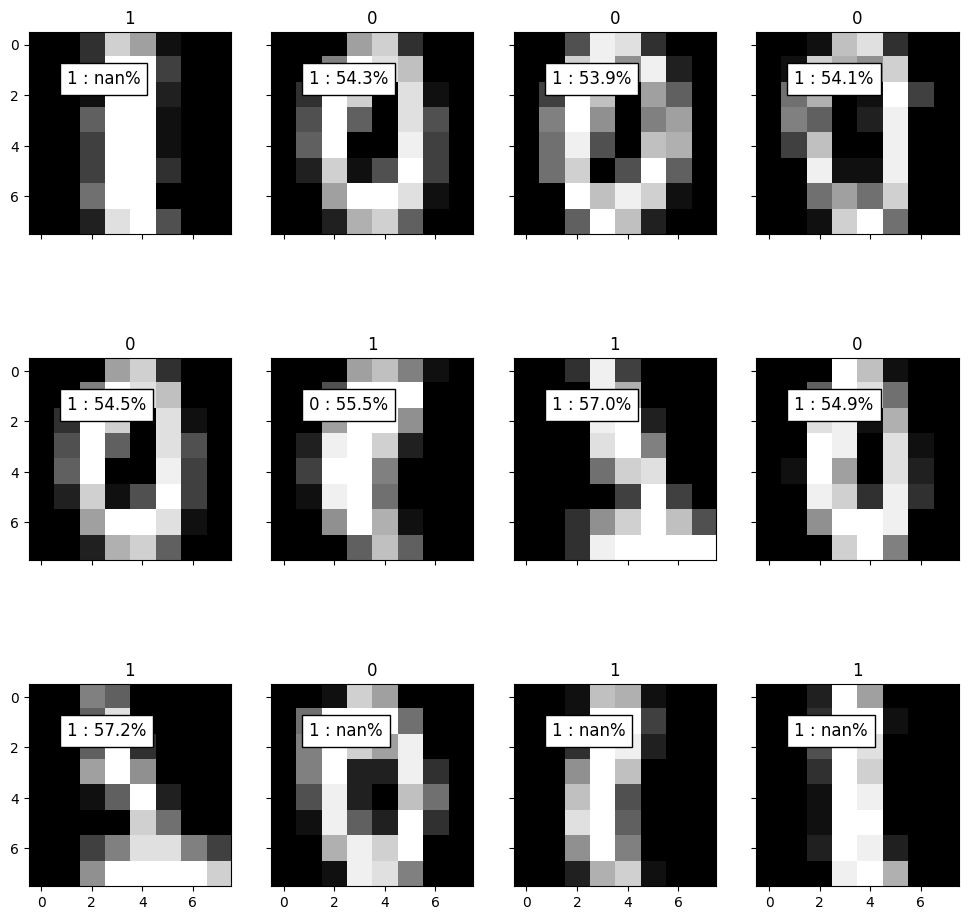

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    plt_ax.imshow(inp.reshape(8,8), cmap='gray')

    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)


fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(12, 12), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, len(val_dataset)))
    im_val, label = val_dataset[random_characters]

    imshow(im_val, title=label, plt_ax=fig_x)

    predicted_label = model.predict_one(im_val)

    prob_pred = model.predict_one(im_val, predict_proba=True)
    predicted_proba = np.max(prob_pred)
    predicted_proba *= 100

    predicted_text = "{} : {:.1f}%".format(predicted_label, predicted_proba)

    fig_x.text(1, 1, predicted_text, horizontalalignment='left', verticalalignment='top',fontsize=12, color='black', bbox=dict(facecolor='white', edgecolor='black', pad=5))

# Torchvision MNIST

In [9]:
import torch
import torchvision
from torchvision import transforms

trainset = torchvision.datasets.MNIST("./", transform=transforms.ToTensor(), train=False, download=True)

In [10]:
X, y = [], []

for item in trainset:
    X.append(item[0])
    y.append(item[1])

In [64]:
len(X)

10000

In [65]:
X[0].shape

torch.Size([1, 28, 28])

In [66]:
y[0]

7

In [11]:
for i in range(len(X)):
    X[i] = torch.flatten(X[i])

In [59]:
for i in range(len(X)):
    X[i] /= 255

In [29]:
X[0].shape

torch.Size([784])

In [12]:
X_reshaped = []
for i in range(len(X)):
    x = [X[i]]
    X_reshaped.append(x)

y_one_hot = np.zeros(len(y))
y_one_hot = list(y_one_hot)
for i in range(len(y)):
    if y[i] == 0:
        y_one_hot[i] = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    elif y[i] == 1:
        y_one_hot[i] = np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
    elif y[i] == 2:
        y_one_hot[i] = np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])
    elif y[i] == 3:
        y_one_hot[i] = np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])
    elif y[i] == 4:
        y_one_hot[i] = np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
    elif y[i] == 5:
        y_one_hot[i] = np.array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
    elif y[i] == 6:
        y_one_hot[i] = np.array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
    elif y[i] == 7:
        y_one_hot[i] = np.array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])
    elif y[i] == 8:
        y_one_hot[i] = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])
    elif y[i] == 9:
        y_one_hot[i] = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

y_one_hot = np.array(y_one_hot)

X_train, X_val, y_train_one_hot, y_val_one_hot = train_test_split(X_reshaped, y_one_hot, train_size=0.8)

In [13]:
y_val = np.zeros(len(y_val_one_hot), dtype=int)

for i in range(len(y_val_one_hot)):
    for j in range(len(y_val_one_hot[i])):
        if y_val_one_hot[i][j] == 1:
            y_val[i] = j
            break

In [ ]:
lib = ctypes.CDLL('./main.so')

train_dataset = Dataset(samples=X_train, targets=y_train_one_hot)
val_dataset = Dataset(samples=X_val, targets=y_val)

layers = [
    Linear(28*28,1000, activation=Sigmoid(), dropout=1.0),
    Linear(1000,10, activation=Softmax()),
]

model = Model(layers=layers, loss=CrossEntropy(), regression=False, max_change=10000000000000)

t_1 = time.time()
model.fit(dataset=train_dataset, n_epoch=1, learning_rate=0.000001, verbose=True, num_cpu=NUM_CPU)
t_2 = time.time()
print(t_2 - t_1)

predictions = model.predict(X_val)

accuracy_score(y_true=y_val, y_pred=predictions) * 100

[18-07-2025 18:01:17.695570] - INFO - Preparing the dataset.
[18-07-2025 18:01:17.705986] - INFO - Dataset preparation completed.
[18-07-2025 18:01:17.706169] - INFO - Training has started.
Epoch 1 / 1. Loss: -2.933843
[18-07-2025 18:03:56.872407] - INFO - Training is over.
159.29042601585388


10.75

159.29042601585388

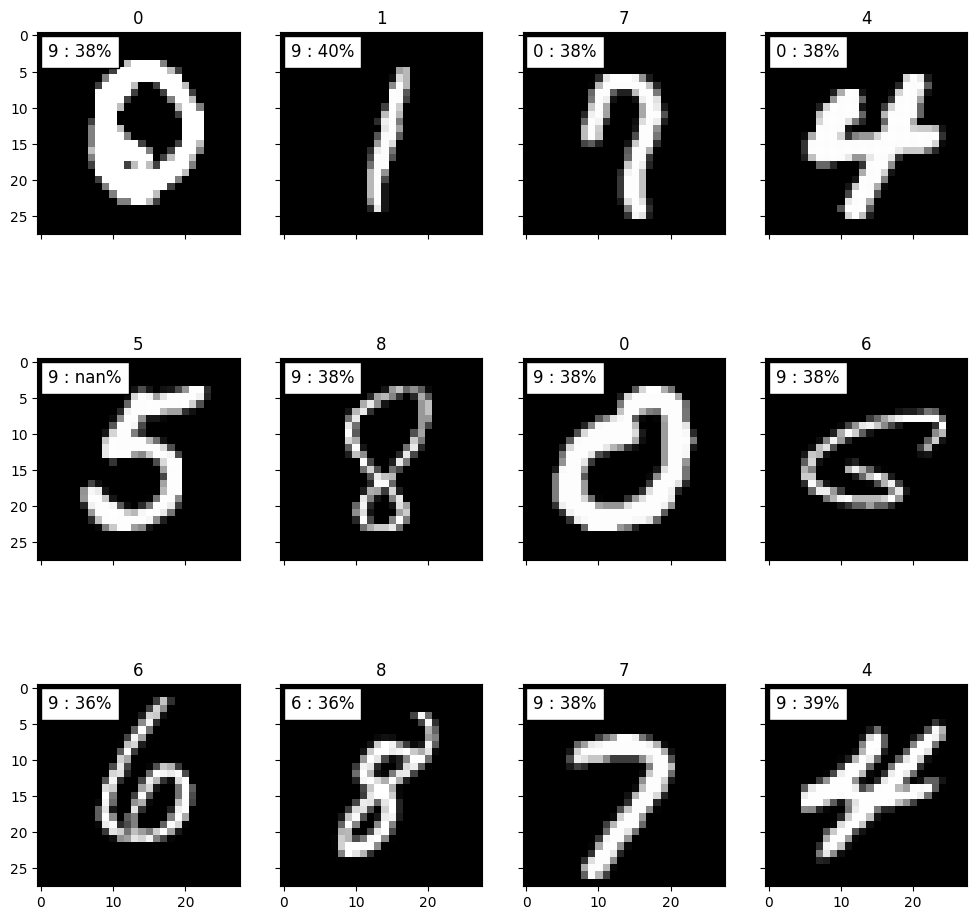

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    plt_ax.imshow(inp.reshape(28,28), cmap='gray')

    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)


fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(12, 12), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, len(val_dataset)))
    im_val, label = val_dataset[random_characters]

    imshow(im_val, title=label, plt_ax=fig_x)

    predicted_label = model.predict_one(im_val)

    prob_pred = model.predict_one(im_val, predict_proba=True)
    predicted_proba = np.max(prob_pred)
    predicted_proba *= 100

    predicted_text = "{} : {:.1f}%".format(predicted_label, predicted_proba)

    fig_x.text(1, 1, predicted_text, horizontalalignment='left', verticalalignment='top', fontsize=12, color='black', bbox=dict(facecolor='white', edgecolor='black', pad=5))